# Bidirectional LSTM Encoder and Decoder with Attention model

# Applied to a Text Summarization task 


We will describe the components of this model, analyze their operation and build a simple model that we will apply to a small-scale NMT problem (Neural Machine Translation). To read more about the problem that we will address and to know how the basic attention mechanism works, I recommend you to read my previous  post [ "A Guide on the Encoder-Decoder Model and the Attention Mechanism"](https://medium.com/better-programming/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb) and check the [ repository](https://github.com/edumunozsala/NMT-encoder-decoder-Attention).

#Loading the libraries

In [ ]:
!pip install wandb -q

     |████████████████████████████████| 1.8MB 5.7MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 163kB 50.7MB/s 
     |████████████████████████████████| 133kB 50.5MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 


Load and install, if necessary, the python libraries we will use along this notebook. We force to import Tensorflow version 2, if it is available.

In [1]:
import math
import os
import gc
import time
import re
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline 

from google.colab import drive

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

We are going to use Rouge metric from the datasets library 

In [3]:
!pip install datasets
!pip install rouge_score

In [4]:
# Load the huggingface datasets library
import datasets

In [ ]:
# WandB – Import the wandb library
import wandb
# Login to wandb to log the model run and all the parameters
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Setting some variables about data location:

In [5]:
# Global parameters
root_folder='/content/drive'
data_folder_name='My Drive/datasets/Inshorts_news'
model_folder_name='My Drive/Projects/Encoder-Decoder-Attention-TS/model/'
checkpoint_folder = "My Drive/Projects/Encoder-Decoder-Attention-TS/ckpt/"
train_filename='cl_Inshorts.csv'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
#valid_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))
# Both train and test set are in the root data directory
train_path = DATA_PATH

Setting some parameters and hyperparameters for encoder-decoder model:

In [6]:
# Parameters for our model
NUM_SAMPLES = 25000 #40000
MAX_VOCAB_SIZE = 2**14

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 2  # Number of epochs to train for.
MAX_SUMM_LENGTH = 12
MAX_TEXT_LENGTH = 60
EMBEDDING_DIM = 300
UNITS = 512
DROPOUT_RATE= 0.2
LEARNING_RATE = 0.001
# Seed
SEED=42
train_frac=0.85
#Experiment parameters
save_checkpoints = False
OOV_TOKEN='<unk>'

### Set a seed to get determinisct results

In [7]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# The dataset and text processing

For this exercise we will use pairs of simple sentences, the source in English and target in Spanish, from the Tatoeba project where people contribute adding translations every day. This is the [link](http://www.manythings.org/anki/) to some traslations in different languages. There you can download the Spanish - English spa_eng.zip file, it contains 124457 pairs of sentences.


The text sentences are almost clean, they are simple plain text, so we only need to remove dots that are not a end of sentence symbol and duplicated white spaces. 

The following functions will apply the cleaning mentioned previously:


## Loading the dataset

Mount our Google Drive unit to access the datafiles from the notebook

In [8]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Load the dataset into a pandas dataframe and apply the preprocess function to the input and target columns.

In [9]:
# Load the train dataset: text and summary 
train_df=pd.read_csv(train_filenamepath, header=0, usecols=[0,1], 
               nrows=NUM_SAMPLES)

print('Number of train sentences: ',len(train_df))
#print('Number of validation sentences: ',len(valid_df))

input_train = '<start> '+train_df['text'].values+' <end>'
target_train = '<start> '+train_df['summary'].values+' <end>'

print(input_train[10])
print(target_train[50])

Number of train sentences:  25000
<start> england pacer james anderson clean bowled cheteshwar pujara with an in-swinging delivery in the visakhapatnam test . the ball came back in after pitching and went through the bat and pad of the batsman to knock out the middle stump . the pacer had bowled a short pitch delivery earlier in the over to push the batsman on to the back foot . <end>
<start> apple ceo tim cook earned $ 373 mn in stock in 5 years <end>


In [10]:
#Delete the dataframe and release the memory (if it is possible)
del train_df
#del valid_df
gc.collect()

0

# Tokenize the text data

Next, let's see how to prepare the data for our model. It is very simple and the steps are the following:

- Create the vocabulary from the corpus using Subword tokenization, breaking words into “subword units” - strings of characters like ing or eau - that allow the downstream model to make intelligent decisions on words it doesn’t recognize.
- Calculate the maximum length of the input and output sequences.
- Tokenize the data, convert the raw text into a sequence of integers. Once we define the vocabulary, we use the encode method to get the token for every word in the corpus.
- Remove sentences longer that the max length defined.
- Padding the sentences: we need to pad zeros at the end of the sequences so that all sequences have the same length. Otherwise, we won't be able train the model on batches

In [11]:
def word_tokenize(input_data, max_vocab_size, max_length=None, OOV_token= None, 
                  filters='', padding= True):
    # Create a tokenizer for the input texts and fit it to them 
    tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters, oov_token=OOV_token)
    tokenizer.fit_on_texts(input_data)
    # Tokenize and transform input texts to sequence of integers
    input_sequences = tokenizer.texts_to_sequences(input_data)
    # Claculate the max length
    input_max_len = max(len(s) for s in input_sequences)
    # Apply padding and truncate if required
    if padding:
        if max_length != None:
            input_sequences = pad_sequences(input_sequences, maxlen=max_length, 
                                            truncating='post', padding='post')
        else:
            input_sequences = pad_sequences(input_sequences, padding='post')

    return input_sequences, tokenizer, input_max_len

In [12]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, input_max_length = word_tokenize(input_train,MAX_VOCAB_SIZE,MAX_TEXT_LENGTH, OOV_TOKEN)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, output_max_length = word_tokenize(target_train,MAX_VOCAB_SIZE, MAX_SUMM_LENGTH, OOV_TOKEN)

In [ ]:
# Check the tokenize function
print(encoder_inputs[:3])
print(decoder_outputs[:3])
print(input_max_length, output_max_length)

[[   10  9725  4790  3569    16   204    26     2 13896  1705     6   285
    161    33  2059 13897  1101     3  1940     2  5456   966    21    47
   3006  1101     4  3569     3    50    20     2  2060   967    26     2
   1705     3    43  7637    23     2  9726  5457  4791   106   149     2
    253     4  3569    16    41   229     7  5458     8   145   967     4]
 [   10  2445   286    16    41     2   114   264   382   760     5    34
   1941     2   259   827     7    35     6 13898    44   347    33  2445
    286     3     2   418   240    55     3   230    47     2   552  4286
     33 13899  4287  1464    25     2    55     7   552     4   266   853
      3    76    16    41     2   114   264   552    55     7    35     4]
 [   10   116  3891  6377  1307    32  3252 13900  3570  7638    15     2
   2300     7    32   194    54   472  9727    19     4  6377  5459  3570
     33     2  3252   539     8   775     7   882  2446  6377    12  5460
      4    28    20  2061     3    1

Some utilities to convert a tensor or array of tokens to clean text.

In [13]:
def convert(tokenizer, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, tokenizer.index_word[t]))

def tensor_to_text(tokenizer, tensors):
  texts=[]
  for tensor in tensors:
      text=[tokenizer.index_word[t] for t in tensor if t!=0]
      texts.append(' '.join(text))

  return texts

In [ ]:
#convert( tokenizer_inputs,encoder_inputs[50])
#convert(tokenizer_outputs ,decoder_outputs[50])
t= tf.ones((64,12), dtype=tf.int64)
tensor_to_text(tokenizer_inputs, t.numpy())
#tensor_to_text(tokenizer_inputs, encoder_inputs[0:2])

# Create the batch data generator for train and validation

In [14]:
train_enc_inputs, val_enc_inputs, train_dec_outputs, val_dec_outputs, = train_test_split(encoder_inputs, decoder_outputs,
                                                                                       train_size=train_frac,random_state=SEED, shuffle=True )
print(train_enc_inputs.shape)
print(train_dec_outputs.shape)
print(val_enc_inputs.shape)
print(val_dec_outputs.shape)

(21250, 60)
(21250, 12)
(3750, 60)
(3750, 12)


Set some parameters to define the datasets generators:

In [15]:
BUFFER_SIZE = len(train_enc_inputs)
steps_per_epoch = len(train_enc_inputs)//BATCH_SIZE
val_steps_per_epoch = len(val_enc_inputs)//BATCH_SIZE

num_words_inputs=len(tokenizer_inputs.word_index)+1
num_words_outputs=len(tokenizer_outputs.word_index)+1
input_vocab_size = tokenizer_inputs.num_words
output_vocab_size = tokenizer_outputs.num_words
print('Size of Input Vocabulary: ', input_vocab_size)
print('Size of Output Vocabulary: ', output_vocab_size)

Size of Input Vocabulary:  16384
Size of Output Vocabulary:  16384


- Create a batch data generator: we want to train the model on batches, group of sentences, so we need to create a Dataset using the tf.data library and the function batch_on_slices on the input and output sequences.

In [16]:
# Define a train dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (train_enc_inputs, train_dec_outputs))
dataset = dataset.shuffle(train_enc_inputs.shape[0], reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Define a train dataset 
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_enc_inputs, val_dec_outputs))
val_dataset = val_dataset.batch(
    BATCH_SIZE, drop_remainder=True)

val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
print(type(example_input_batch))

<class 'tensorflow.python.framework.ops.EagerTensor'>


# Create the embedding matrix

In [17]:
import spacy
# The next command sould only be ran for the first time
#!python -m spacy download en_vectors_web_lg


In [18]:
nlp = spacy.load('en_vectors_web_lg')

In [19]:
# CREATING AN EMBEDDING MATRIX
#max_tokens = inpit_vocab:size, emd_dim 300, vocab nlp.vocab idx2word
def create_embedding_matrix(max_tokens, embedding_dim, vocab, idx2word):
    embedding_matrix = np.random.randn(max_tokens, embedding_dim)
    for i in range(1,max_tokens):
        if nlp.vocab[idx2word[i]].has_vector:
          embedding_matrix[i] = nlp.vocab[idx2word[i]].vector
    
    return embedding_matrix

In [20]:
input_embedding_matrix = create_embedding_matrix(input_vocab_size, EMBEDDING_DIM, nlp.vocab, tokenizer_inputs.index_word)
output_embedding_matrix = create_embedding_matrix(output_vocab_size, EMBEDDING_DIM, nlp.vocab, tokenizer_outputs.index_word)

In [21]:
output_embedding_matrix.shape

(16384, 300)

# Building a Bidirectional Encoder and a Decoder with LSTMs

# The Encoder

Encoder implementation

In [22]:
# Create the Encoder based on Bidirectional LSTMs
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout_rate, embedding_matrix):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.dropout_rate = dropout_rate
        #self.outputs = {}
        self.states = {}
        if embedding_matrix is not None:
            #self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, weights = [embedding_matrix])
            self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, 
                                                       embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix))
        else:
            self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim)

        self.lstmb1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout = self.dropout_rate,
                                                                        go_backwards=True), merge_mode='sum')

        self.lstmb2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state= True,
                                                                         dropout=self.dropout_rate, go_backwards=True), merge_mode='sum')
        
        self.lstmb3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        dropout=self.dropout_rate, go_backwards=True), merge_mode='sum')
    
    def call(self, x, training=True):
        x = self.embedding(x)
        #print('x shape: ',x.shape)
        x, hidden_forward, cell_forward, hidden_backward, cell_backward = self.lstmb1(x,
                                                                                      training=training)
        x, hidden_forward, cell_forward, hidden_backward, cell_backward = self.lstmb2(x, initial_state= [hidden_forward, 
                                                                                                        cell_forward, hidden_backward, cell_backward],
                                                                                      training=training)
        outputs, self.states["for_h"], self.states["for_c"], self.states["bac_h"], self.states["bac_c"] = self.lstmb3(x, initial_state=[hidden_forward, 
                                                                                                        cell_forward, hidden_backward, cell_backward], 
                                                                                                        training=training)
        return outputs, self.states
        #return self.outputs, self.states

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)),tf.zeros((self.enc_units, self.enc_units))]

An example on how to create and call the encoder

In [22]:
encoder = Encoder(input_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, 0.2, None) #input_embedding_matrix)

# sample input
#sample_hidden = encoder.initialize_hidden_state()
print('Input shape: ', example_input_batch.shape)
outputs, states = encoder(example_input_batch) #, sample_hidden)
#hidden_forward, hidden_backward, cell_forward, cell_backward = states
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(outputs.shape))
print ('Encoder Forward states shape: (batch size, units) {} - {}'.format(states["for_h"].shape, states["for_c"].shape))
print ('Encoder For-Back Cell state shape: (batch size, units) {} - {}'.format(states["bac_h"].shape, states["bac_c"].shape))

Input shape:  (64, 60)
Encoder output shape: (batch size, sequence length, units) (64, 60, 512)
Encoder Forward states shape: (batch size, units) (64, 512) - (64, 512)
Encoder For-Back Cell state shape: (batch size, units) (64, 512) - (64, 512)


# The Attention mechanism 

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    #query == states
    #values == output
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# The Decoder



In [24]:
# DEFINING THE DECODER CLASS OF MODEL

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dropout_rate, embedding_matrix):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.dropout_rate = dropout_rate
    if embedding_matrix is not None:
        #self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, weights = [embedding_matrix])
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim, 
                                                   embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix))
    else:
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim= embedding_dim)

    self.lstm1 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)

    self.lstm2 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                  dropout=self.dropout_rate)

    self.lstm3 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=self.dropout_rate)

    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)
    

  #def call(self, x, enc_output, hidden, Training=True):
  def call(self, inputs, Training=True):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x, enc_output, hidden = inputs

    x = self.embedding(x)
    #print('x shape: ',x.shape)

    x, h, c = self.lstm1(x, initial_state = hidden)
    x, h ,c = self.lstm2(x, initial_state= [h, c])
    
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(h, enc_output)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # applying lstm
    x, h, c = self.lstm3(x, initial_state= [h, c])
    states = [h, c]

    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(x)

    return x, states, attention_weights

The next cell create a Decoder and call it to test it. Later we create the decoder object to use in our model.

In [46]:
decoder = Decoder(output_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, 0.2, None) #output_embedding_matrix)

sample_hidden = [tf.add(states["for_h"], states["bac_h"]), tf.add(states["for_c"], states["bac_c"])]
sample_output = outputs            
inputs = (tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_output, sample_hidden)
sample_decoder_output, dec_states, attention_weights = decoder(inputs)

hidden, cell = dec_states
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print ('Decoder hidden shape: (batch_size, LSTM units) {}'.format(hidden.shape))
print ('Decoder cell shape: (batch_size, LSTM units) {}'.format(cell.shape))
print ('Attention shape: (batch_size, LSTM units) {}'.format(attention_weights.shape))

Decoder output shape: (batch_size, vocab size) (64, 16384)
Decoder hidden shape: (batch_size, LSTM units) (64, 512)
Decoder cell shape: (batch_size, LSTM units) (64, 512)
Attention shape: (batch_size, LSTM units) (64, 60, 1)


### Create the WandB project and configuration

In [ ]:
# Set the project name and run name for wandB
project_name="Text-summa-EncDec-Attention"
demo_name="test_run"

# Set the project name, the run name, the description
wandb.init(project=project_name, name=demo_name, 
               notes="Training en encoder-decoder with attention for Text Summarization")
# WandB – Config is a variable that holds and saves hyperparameters and inputs
# Defining some key variables that will be used later on in the training  
config = wandb.config          # Initialize config
config.BATCH_SIZE = BATCH_SIZE    # input batch size for training (default: 64)
config.EPOCHS = EPOCHS        # number of epochs to train (default: 10)
config.SEED = SEED               # random seed (default: 42)
config.MAX_VOCAB_SIZE = MAX_VOCAB_SIZE
config.MAX_SUMM_LENGTH = MAX_SUMM_LENGTH 
config.MAX_TEXT_LENGTH = MAX_TEXT_LENGTH
config.NUM_SAMPLES = NUM_SAMPLES
config.RNN_UNITS = UNITS
config.EMBEDDING_DIM = EMBEDDING_DIM
config.LEARNING_RATE = LEARNING_RATE

# Log metrics with wandb
#wandb.watch(transformer, log="all")


wandb: Currently logged in as: edumunozsala (use `wandb login --relogin` to force relogin)


# Defining and loading the rouge metric 

In [25]:
def parse_score(result):
    return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}

metric = datasets.load_metric('rouge')
print(metric)

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each predictions
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_agregator: Return aggregates if this is set to True
Retu

# The Loss function and the optimizer

Now that we have described in detail the components in the paper we are ready to implement them and train a transformer model on a NMT problem. It is a toy problem for educational purposes.

We need to create a custom loss function to mask the padding tokens and we define the Adam optimizer described in the paper, with beta1 = 0.9, beta2 = 0.98 and epsilon= 10e-9. And then we create a scheduler to vary the learning rate over the training process according to:

$lrate = d_{model}^{-0.5}*min(step\_num^{-0.5}, step\_num*warmup\_steps^{-1.5})$


In [26]:
def loss_function(target, pred):
    mask = tf.math.logical_not(tf.math.equal(target, 0))
    loss_ = loss_object(target, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


And that's all, we have all the necessary elements to train our model using an usual loop for sequence-to-sequence tasks:
- For every iteration on the batch generator that produce batch size inputs and outputs
- Get the input sequence from 0 to length-1 and the actual outputs from 1 to length, the next word expected at every sequence step.
- Call the transformer to get the predictions
- Calculate the loss function between the real outputs and the predictions
- Apply the gradients to update the weights in the model
- Calculate the mean loss and the accuracy for the batch data
- Show some results and save the model in every epoch

## The Train Step function

You will define a regular training step and test step.

Within the strategy's scope, define `train_step(inputs)`

- `inputs` will be a tuple containing `(images, labels)`.
- Create a gradient tape block.
- Within the gradient tape block:

  - Call the model, passing in the images and setting training to be `True`.
  - Call the `compute_loss function` (defined earlier) to compute the training loss (complete this part).
  - Use the gradient tape to calculate the gradients.
  - Use the optimizer to update the weights using the gradients.

In [27]:
@tf.function
def train_step(inputs):
# Not using encoder hidden
  inp, targ = inputs
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_states = encoder(inp)

    #dec_hidden = enc_hidden
    dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"], 
                                enc_states["bac_c"]) ]

    dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      #call(self, x, enc_output, hidden)

      #predictions, dec_hidden = decoder((dec_input, enc_output, dec_hidden))
      predictions, dec_hidden, _ = decoder((dec_input, enc_output, dec_hidden))
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

## Define test_step
Also within the strategy's scope, define `eval_step(inputs)`

- `inputs` is a tuple containing `(images, labels)`.
- Call the model, passing in the images and set training to `False`, because the model is not going to train on the test data. 
- Use the `loss_object`, which will compute the test loss. Check `loss_function`, defined earlier, to see what parameters to pass into `loss_object`.
- Next, update test_loss (the running test loss) with the t_loss (the loss for the current batch).

In [28]:
@tf.function
def eval_step(inputs):

    inp, targ = inputs
    loss = 0

    enc_output, enc_states = encoder(inp, False)
    dec_hidden = [ tf.add(enc_states["for_h"], enc_states["bac_h"]), tf.add(enc_states["for_c"], 
                          enc_states["bac_c"]) ]
    dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']] * BATCH_SIZE, 1)
    result_ids = tf.one_hot([tokenizer_outputs.word_index['<start>']]*BATCH_SIZE, 
                            output_vocab_size, dtype=tf.float32)
    result_ids = tf.expand_dims(result_ids,axis=1)

    #print('Init: ',result_ids.shape,result_ids.dtype)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      #decoder(dec_input, enc_output, dec_hidden)
      #predictions, dec_hidden = decoder(dec_input, enc_output, dec_hidden)
      predictions, dec_hidden,_ = decoder((dec_input, enc_output, dec_hidden), False)
      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)
      #
      #print('Predic:',predictions.shape)
      #predicted_ids = tf.argmax(predictions, axis=1)
      #print(predicted_ids.shape, predicted_ids.dtype)
      #print(type(predicted_ids))
      result_ids = tf.concat([result_ids , tf.expand_dims(predictions, axis=1)], 1)
      #t = tf.concat([t,tf.expand_dims(s, axis=1)], axis=1)
          #np.concatenate(([result_ids , predicted_ids ]), axis=1)
      #result_ids = result_ids.T
      #print(result_ids.shape, type(result_ids))

    #result_ids = result_ids.T
    #print('Fin: ',result_ids.shape, type(result_ids))

    batch_loss = (loss / int(targ.shape[1]))
   
    return batch_loss, result_ids

In [29]:
def main_train(dataset, val_dataset, n_epochs, steps_per_epoch, val_steps_per_epoch,
               save_checkpoints=False, logging= False, print_every=50):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  train_losses = []
  val_losses = []
  val_metric = []

  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    # Reset the losss and accuracy calculations
    train_loss.reset_states()
    #Initialize the encoder states
    #enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    #for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    for (batch, dataset_inputs) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(dataset_inputs)
        train_loss.update_state(batch_loss)

        total_loss += batch_loss

        if batch % print_every == 0:
            print('Train: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    epoch_loss = total_loss / steps_per_epoch
    train_losses.append(epoch_loss)
    # Register in wandb
    if logging:
        wandb.log({"Training Loss": epoch_loss})

    # Reset the validation losss and accuracy calculations
    val_loss.reset_states()
    total_loss = 0
    # Evaluation loop
    #for (batch, (inp, targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    for (batch, dataset_inputs) in enumerate(val_dataset.take(val_steps_per_epoch)):
        _, targ = dataset_inputs
        batch_loss, preds = eval_step(dataset_inputs)#, enc_hidden)
        val_loss.update_state(batch_loss)

        total_loss += batch_loss
        # Add the predictions to the metric
        #Convert sequence to text
        #print(preds.shape, targ.shape)
        preds = tf.argmax(preds, axis=-1)
        #print(preds.shape, preds.dtype)
        predictions = tensor_to_text(tokenizer_outputs, preds.numpy())
        #references = tokenizer_outputs.sequences_to_texts(targ)
        references = tensor_to_text(tokenizer_outputs, targ.numpy())
        metric.add_batch(predictions=predictions, references=references)

    epoch_loss = total_loss / val_steps_per_epoch
    val_losses.append(epoch_loss)
    # compute the metric
    metric_results = metric.compute()
    metric_score = parse_score(metric_results)
    # Save the validation metric
    val_metric.append(metric_score['rouge1'])
    # Register in wandb
    if logging:
        wandb.log({"Validation Loss": val_loss.result(), #})
                   "Rouge1": metric_score['rouge1'],
                   "Rouge2": metric_score['rouge2'],
                   "RougeL": metric_score['rougeL']})

    #Show Validation results
    print("\nValidation: Epoch {} Batch {} Loss {:.4f} Rouge1 {:.4f} Rouge2 {:.4f} RougeL {:.4f}".format(
                epoch+1, batch, epoch_loss,metric_score['rouge1'], metric_score['rouge2'],
                metric_score['rougeL']))

    # Checkpoint the model on every epoch    
    if ((epoch + 1) % 2 == 0) and save_checkpoints:    
      ckpt_save_path = ckpt_manager.save()
      print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("\nTime for 1 epoch: {} secs\n".format(time.time() - start))

  return train_losses, val_losses, val_metric

Setting the hyperparameters and parameters of the model and training process:

Now we define and create all the elements to train the model and evaluate it.

In [30]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
encoder = Encoder(input_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, DROPOUT_RATE, input_embedding_matrix)
#attention_layer = BahdanauAttention(128)
decoder = Decoder(output_vocab_size, EMBEDDING_DIM, UNITS, BATCH_SIZE, DROPOUT_RATE, output_embedding_matrix)

# Define a categorical cross entropy loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction="none")
# Define a metric to store the mean loss of every epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Define a matric to save the accuracy in every epoch
#train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
# Define a metric to store the mean loss of every epoch
val_loss = tf.keras.metrics.Mean(name="val_loss")
# Define a matric to save the accuracy in every epoch
#val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="val_accuracy")

# Create the scheduler for learning rate decay
#leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(#leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

It is very useful to checkpoint and save our model during training. Training can take a lot of time and we can restore the model for future training or use.

In [31]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [32]:
# Train the model
EPOCHS = 10
train_losses, val_losses, val_metric = main_train(dataset, val_dataset, EPOCHS, steps_per_epoch, 
                                                  val_steps_per_epoch, save_checkpoints, logging= False)

Starting epoch 1
Train: Epoch 1 Batch 0 Loss 7.7457
Train: Epoch 1 Batch 50 Loss 6.0940
Train: Epoch 1 Batch 100 Loss 6.0502
Train: Epoch 1 Batch 150 Loss 5.7449
Train: Epoch 1 Batch 200 Loss 5.5274
Train: Epoch 1 Batch 250 Loss 5.4475
Train: Epoch 1 Batch 300 Loss 5.2740

Validation: Epoch 1 Batch 57 Loss 5.4137 Rouge1 24.3313 Rouge2 1.2589 RougeL 24.1555

Time for 1 epoch: 114.37371826171875 secs

Starting epoch 2
Train: Epoch 2 Batch 0 Loss 5.3174
Train: Epoch 2 Batch 50 Loss 5.4182
Train: Epoch 2 Batch 100 Loss 5.1741
Train: Epoch 2 Batch 150 Loss 5.1591
Train: Epoch 2 Batch 200 Loss 5.2698
Train: Epoch 2 Batch 250 Loss 4.9457
Train: Epoch 2 Batch 300 Loss 5.2912

Validation: Epoch 2 Batch 57 Loss 5.1647 Rouge1 25.6410 Rouge2 1.7494 RougeL 25.3924

Time for 1 epoch: 67.87893605232239 secs

Starting epoch 3
Train: Epoch 3 Batch 0 Loss 4.9239
Train: Epoch 3 Batch 50 Loss 4.6909
Train: Epoch 3 Batch 100 Loss 4.6559
Train: Epoch 3 Batch 150 Loss 4.8531
Train: Epoch 3 Batch 200 Loss 4.6

## Save the model


In [34]:
encoder_model_path = os.path.join(model_folder_name, 'encoder')
tf.saved_model.save(encoder, encoder_model_path)
#encoder.save_weights(encoder_model_path, save_format='tf')
#tf.saved_model.save(encoder, encoder_model_path, signatures=encoder.call.get_concrete_function(
#        [tf.TensorSpec(shape=[None, MAX_TEXT_LENGTH], dtype=tf.int32, name='x'),
#         tf.TensorSpec(shape=[None, UNITS], dtype=tf.float32, name="hidden")]))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: My Drive/Projects/Encoder-Decoder-Attention-TS/model/encoder/assets


In [35]:
decoder_model_path = os.path.join(model_folder_name, 'decoder')
tf.saved_model.save(decoder, decoder_model_path)

INFO:tensorflow:Assets written to: My Drive/Projects/Encoder-Decoder-Attention-TS/model/decoder/assets


## Show some results from training

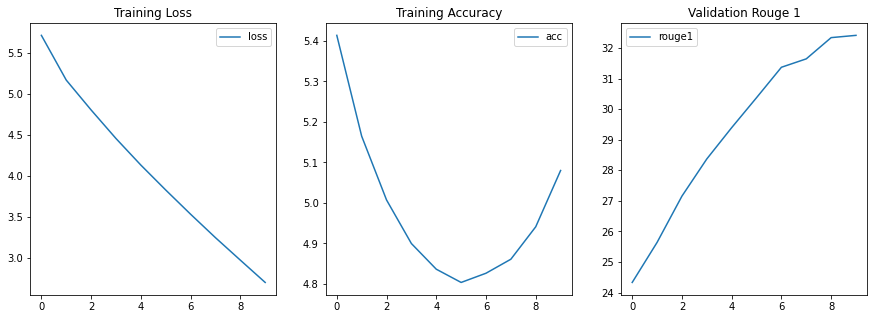

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
# plot some data
ax1.plot(train_losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(val_losses, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
# accuracies
ax3.plot(val_metric, label='rouge1')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax3.set_title('Validation Rouge 1')
ax3.legend()
plt.show()

# Make predictions

We have seen the scores obtained after training but what we are interested in making predictions and see how the model works with new sentences. The predict function will input a tokenize sentence to the model and return the predicted new sentence, in our example, a translation from english to spanish. 
- Tokenize the input sentence to a sequence of tokens
- Set the initial output sequence to the SOS token
- Until we reach the max length or the eos token is returned by the model
- Get the next word predicted. The model returns the logits, remember that the softmax function is applied in the loss calculation.
- Get the index in the vocabulary of the word with the highest probability
- Concat the next word predicted to the output sequence

In [34]:
def predict(sentence):
  attention_plot = np.zeros((MAX_SUMM_LENGTH, MAX_TEXT_LENGTH))

  sentence = '<start> '+sentence+' <end>'

  inputs = [tokenizer_inputs.word_index[i] if tokenizer_inputs.word_index[i] < input_vocab_size 
            else tokenizer_inputs.word_index['<unk>'] for i in sentence.split(' ')]
  inputs = pad_sequences([inputs], maxlen=MAX_TEXT_LENGTH,padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, states = encoder(inputs) #, hidden)

  #dec_hidden = enc_hidden
  dec_hidden = [tf.add(states["for_h"], states["bac_h"]), tf.add(states["for_c"], states["bac_c"])]
  dec_input = tf.expand_dims([tokenizer_outputs.word_index['<start>']], 0)

  for t in range(MAX_SUMM_LENGTH):
    predictions, dec_hidden, attention_weights = decoder((dec_input,
                                                          enc_out,
                                                          dec_hidden))

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += tokenizer_outputs.index_word[predicted_id] + ' '

    if tokenizer_outputs.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [35]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

And finally our last function receives a sentence in english, calls the transformer to translate it to spanish and shows the result

In [36]:
def summarize(sentence):
  result, sentence, attention_plot = predict(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

First, we explore the predictions on sentences of our training dataset:

Input: <start> england pacer james anderson clean bowled cheteshwar pujara with an in-swinging delivery in the visakhapatnam test . the ball came back in after pitching and went through the bat and pad of the batsman to knock out the middle stump . the pacer had bowled a short pitch delivery earlier in the over to push the batsman on to the back foot . <end>
Predicted translation: mirza-hingis draw open in aus open semis <end> 


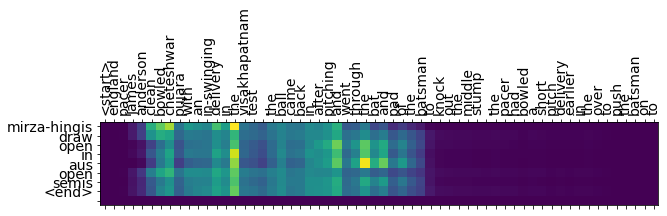

In [37]:
summarize('england pacer james anderson clean bowled cheteshwar pujara with an in-swinging delivery in the visakhapatnam test . the ball came back in after pitching and went through the bat and pad of the batsman to knock out the middle stump . the pacer had bowled a short pitch delivery earlier in the over to push the batsman on to the back foot .')

Next, let's predict some new sentences on diferent topics:

In [ ]:
#Show some translations
sentence = "This is a problem to deal with."
print("Input sentence: {}".format(sentence))
predicted_sentence = translate(sentence)
print("Output sentence: {}".format(predicted_sentence))

Input sentence: This is a problem to deal with.
Output sentence: Este problema es un problema con eso.
